In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# preparing the data

In [2]:
data=pd.read_csv("ratings.dat",sep="::",header=None)

/usr/local/share/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [3]:
data.head()

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
data.rename(columns={0:'UserID',1:'MovieID',2:'Rating',3:'Timestamp'},inplace=True)

In [5]:
data.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [6]:
data=data[['UserID','MovieID','Rating']]

## dataset of 1 million M dataset

In [7]:
len(data)

1000209

## clean the data

In [8]:
from sklearn.preprocessing import LabelEncoder

In [9]:
Users_label=LabelEncoder()
Users_label.fit(data['UserID'])
Movie_label=LabelEncoder()
Movie_label.fit(data['MovieID'])

LabelEncoder()

In [10]:
Users_label.transform([1])

array([0])

In [11]:
data["Users"]=Users_label.transform(data.UserID)

In [12]:
data["Movies"]=Movie_label.transform(data.MovieID)

In [13]:
data.head()

,UserID,MovieID,Rating,Users,Movies
0,1,1193,5,0,1104
1,1,661,3,0,639
2,1,914,3,0,853
3,1,3408,4,0,3177
4,1,2355,5,0,2162


Now we only make use of the used_data1 to do our model

In [14]:
used_data=data.pivot(index="Users",columns="Movies",values='Rating')

In [15]:
try_data=np.ones_like(used_data.values)

## split the data

### training, validation, test

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
train,test=train_test_split(data[['Rating','Users','Movies']],test_size=0.2,random_state=999)

#### change them into numpy.array

In [18]:
train,test=train.values,test.values

In [19]:
try_data.dtype

dtype('float64')

1. u=1,000,000
2. r=1,2,3,4,5

Goal: predict r_(u,i) for those unobserved objects

3. valuation: MSE

4. you need to do a crossvalidation in order to find the best space

5. we will learn b_u, b_i, p_u, p_i 4 kinds of factors, and P_u U F, P_i I F in total. F-> factors of that movies.

6. for the loss function. 

7. training: training with stochastic gradient descent. with a batch_size. 

8. pay attention to the parameter initialization.

# Functions

## initialization

In [20]:
def initialization(data:np.ndarray,k:int):
    '''
    data: the frame of the whole dataset: a frame that has n rows of users and m cols of movies
          the data in this frame is not important
    '''
    users=data.shape[0]
    movies=data.shape[1]
    b_u=np.random.normal(0,1e-4,users)
    b_i=np.random.normal(0,1e-4,movies)
    
    for_pq=1/(max(1,np.sqrt(k)))
    pu=np.random.normal(0,for_pq,[users,k])
    pi=np.random.normal(0,for_pq,[movies,k])
    
    
    u=np.nanmean(data)
    return u,b_u,b_i,pu,pi
    

## loss function

In [21]:
def loss(matrix_,u,b_u,b_i,pu,pi,lambda_):
    '''
    matrix_: the true matrix of that ratings
    u: the mean of all data
    b_u, b_i  user bias and movie bias
    pu,pi user and movie embeddings
    '''
    matrix_telda=u+b_u[:,np.newaxis]+b_i[np.newaxis,:]+np.dot(pu,pi.T)
    matrix_telda=(matrix_-matrix_telda)**2+ lambda_* (np.sum(pu**2,1)[:,np.newaxis]+np.sum(pi**2,1)[np.newaxis,:])/2
#     N=(np.isnan(matrix_telda)==False).sum()
    
#     return np.nansum(matrix_telda)
    return np.nanmean(matrix_telda)

In [22]:
#  using the index to extract the matrix
def loss_use(matrix_,u,b_u,b_i,pu,pi,user_index,movie_index,lambda_):
    '''
    matrix_: the true matrix of that ratings
    u: the mean of all data
    b_u, b_i  user bias and movie bias
    pu,pi user and movie embeddings
    '''
    row=user_index[:,np.newaxis]
    col=movie_index[np.newaxis,:]
    return loss(matrix_[row,col],u,b_u[user_index],b_i[movie_index],pu[user_index],pi[movie_index],lambda_ )    

In [23]:
def count(matrix_,user_index,movie_index):
    '''
    counting how many non-nan values in our batch matrix selected for the training
    '''
    row=user_index[:,np.newaxis]
    col=movie_index[np.newaxis,:]
    N=np.sum(np.isnan(matrix_[row,col])==False)
    return N
    
    

## gradient

In [24]:
# matrix,u,b_u,b_i,pu,pi,user_index,movie_index,lambda_=try_data,u,b_u,b_i,pu,pi,a,b,10

def gradient(matrix,u,b_u,b_i,pu,pi,user_index,movie_index,lambda_):
    '''
    output the gradient for selected users and movies
    '''
    
    row=user_index[:,np.newaxis]
    col=movie_index[np.newaxis,:]

    rate_telda=u+b_u[user_index][:,np.newaxis]+b_i[movie_index][np.newaxis,:]+np.dot(pu[user_index],pi[movie_index].T)

    dif=matrix[row,col]-rate_telda

    b_u_gra=-np.nansum(dif,1)
    b_i_gra=-np.nansum(dif,0)

    # np.nanprod()

    pu_cal=dif[:,np.newaxis,:]*pi[movie_index].T[np.newaxis,:,:]
    pi_cal=dif.T[:,np.newaxis,:]*pu[user_index].T[np.newaxis,:,:]

    pu_cal=-pu_cal+lambda_*pu[user_index][:,:,np.newaxis]
    pi_cal=-pi_cal+lambda_*pi[movie_index][:,:,np.newaxis]

    pu_gra=np.nansum(pu_cal,2)
    pi_gra=np.nansum(pi_cal,2)
    # pu_gra=-np.dot(dif,pi[movie_index].T)+lambda_*pu[user_index]
    # pi_gra=-np.dot(dif.T,pu[user_index])+lambda_*pi[movie_index]

    #  due to NaN

    return b_u_gra,b_i_gra,pu_gra,pi_gra

# gradient returns: gradients of bu, bi, pu, pi, and their position ( row, col)

## generate a training functions with epochs

parameters: F etc

In [25]:
def Batch_generate(data,B):
    '''
    output a generation for the data
    data: the data for training or testing
    B: batch size
    '''
    if len(data)%B==0:
        upper=len(data)//B
        np.random.shuffle(data)
        for i in range(upper):
            yield(data[i*B:(i+1)*B])
    else:
        upper=len(data)//B
        np.random.shuffle(data)
        for i in range(upper+1):
            yield(data[i*B:(i+1)*B])

# training 
<p> our goal is to select the best F </p>

In [26]:
def updating(para,gradient,learning_rate,row):
    '''
    used for updating the parameters with the gradient
    para: matrix: the parameter
    gradient: gradient
    learning_rate
    row: np.array 1D the position of the parameter
    '''
    para[row]-=learning_rate*gradient

### check the gradient

before training on the whole dataset,
I will select a batch to see whether the gradient and optimization function will help decrease the loss and reach the optimal

In [27]:
try_data.shape

(6040, 3706)

In [28]:
u,b_u,b_i,pu,pi=initialization(try_data,8)

In [29]:
# b_u_gra,b_i_gra,pu_gra,pi_gra=gradient(try_data,u,b_u,b_i,pu,pi,user_index,movie_index,10)
gen=Batch_generate(train,100)

In [30]:
learning_rate=0.001

In [31]:
all_=next(gen)
user_index,movie_index=all_[:,1],all_[:,2]

In [32]:
loss_list_temp=[]
for i in range(10):
    b_u_gra,b_i_gra,pu_gra,pi_gra=gradient(try_data,u,b_u,b_i,pu,pi,user_index,movie_index,10)
    updating(b_u,b_u_gra,learning_rate,user_index)
    updating(b_i,b_i_gra,learning_rate,movie_index)
    updating(pu,pu_gra,learning_rate,user_index)
    updating(pi,pi_gra,learning_rate,movie_index)
    loss_list_temp.append(loss_use(try_data,u,b_u,b_i,pu,pi,user_index,movie_index,10))

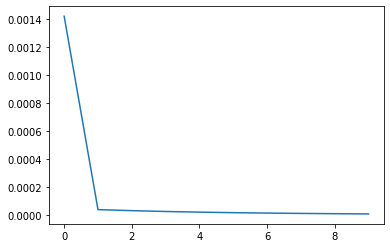

In [33]:
plt.plot(loss_list_temp)

Should be correct

## write a class for training 

In [34]:
class learning:
    def __init__(self,whole_data:np.array,k,lambda_,learning_rate,B=100,epoch=20,show_epoch=5):
        '''
        initilization 
        
        whole_data: the frame of users: only a frame initializing the model's parameter
        k: number of latent factors for users and movies
        lambda_: penalty for training
        B: batch size
        epoch: number of epoch you want to train the model
        show_epoch: frequency you need to show the loss during training
        
        in this class, we only output (show) the loss(MSE) without panalty, which is what the question required
        but we will still compute the gradient with panalty, which is required
        
        '''
        self.data=whole_data*np.NaN
#         clear the frame work

        self.lambda_form=lambda_
        self.learning_rate=learning_rate
        self.B=B
        self.epoch=epoch
        self.show_epoch=show_epoch
        self.k=k
        
        print("generating model with {} parameters".format(self.k))

    
    def clear_data(self,instance):
#         self.data=self.data*np.NaN
#         clear the frame after each use of input_data
        for i in instance:
            self.data[i[1],i[2]]=np.NaN
    
    def input_data(self,instance):
#         for each batch, input the data into the frame
        for i in instance:
            self.data[i[1],i[2]]=i[0]
    
    def loss_(self,user_index,movie_index,train=True):
        '''
        only calculating the loss. lambda is not used here since the true MSE will not be taken into account
        '''
        return loss_use(self.data,self.u,self.b_u,self.b_i,self.pu,self.pi,user_index,movie_index,0)
#         if not training here, just directly return the loss error with out penalty 
        
    def gradient(self,user_index,movie_index):
        self.b_u_gra,self.b_i_gra,self.pu_gra,self.pi_gra=gradient(self.data,self.u,self.b_u,self.b_i,self.pu,self.pi,\
                                                                  user_index,movie_index,self.lambda_)
    
    def update(self,user_index,movie_index):
        self.gradient(user_index,movie_index)
        updating(self.b_u,self.b_u_gra,self.learning_rate,user_index)
        updating(self.b_i,self.b_i_gra,self.learning_rate,movie_index)
        updating(self.pu,self.pu_gra,self.learning_rate,user_index)
        updating(self.pi,self.pi_gra,self.learning_rate,movie_index)
        
        
    def generating_batch(self,train_data):
        '''
        generating the batch generator
        train_data: np.array 2D n*m; rows: n ratings, cols: rating, user position, movie position
        
        '''
        self.batch_generator=Batch_generate(train_data,self.B)
        if len(train_data)%self.B:
            self.loops=len(train_data)//self.B+1
        else:
            self.loops=len(train_data)//self.B
        self.lambda_=self.lambda_form/self.loops
        
# -------------------Notation---------------------
# here the lambda_ which is actually place into the batch, should devided by self.loops, in order that follow the same 
# loss function with panalty
# ------------------------------------------------
            

    def fit(self,train_data):
        '''
        fit the model with training set
        '''
#       input the data to generating the mean: u and other parameters.
        self.input_data(train_data)       
        self.u,self.b_u,self.b_i,self.pu,self.pi=initialization(self.data,self.k)    
        self.clear_data(train_data)
#         clear our data frame
#         first lets calculate the original error
        print("training start: initial total loss: {}".format(self.all_loss(train_data)))        
        print("-----------------------------training begin--------------------------------")
        for i_ in range(self.epoch):
            self.generating_batch(train_data)
            total_loss=0
            for i in range(self.loops):
                all_=next(self.batch_generator)
                self.input_data(all_)
#                 input the data with the instruction from batch B
                user_index,movie_index=all_[:,1],all_[:,2]
#               get the position of users and movies
#               and get rid of the duplicates
                user_index,movie_index=np.unique(user_index),np.unique(movie_index)
#               update the parameters.
                self.update(user_index,movie_index)
                self.clear_data(all_)
            if i_%self.show_epoch==0:
                print("training epoch {} : total loss: {}".format(i_+1,self.all_loss(train_data)))
#         self.clear_data()
    
    
    
    def all_loss(self,test_data):
        '''
        calculate the total loss
        
        test_data: the data you need to calculate the loss
        np.array 2D n*m; rows: n ratings, cols: rating, user position, movie position
        
        '''
#         self.input_data(test_data)
        self.generating_batch(test_data)
#     for easily calculation, use small batch size for the total loss
        total_loss=0
        for i in range(self.loops):
            all_=next(self.batch_generator)
            self.input_data(all_)
            user_index,movie_index=all_[:,1],all_[:,2]
#             print("all_:",len(all_))
            user_index,movie_index=np.unique(user_index),np.unique(movie_index)
#           some of the batch will consist of same user_id or same movie_id, you only need to use the unique one.         
            loss_here=self.loss_(user_index,movie_index,train=False)
            total_loss+=(loss_here/self.loops)
            self.clear_data(all_)
        return total_loss

## Popularity model: F=0

In [35]:
first=learning(try_data,k=0,lambda_=1,learning_rate=0.001,epoch=20,show_epoch=2)

generating model with 0 parameters


In [36]:
train_here,validate_here=train_test_split(train,test_size=0.2)

In [37]:
first.fit(train_here)

training start: initial total loss: 1.2491530478948587
-----------------------------training begin--------------------------------
training epoch 1 : total loss: 1.046180567339768
training epoch 3 : total loss: 0.9281977930330627
training epoch 5 : total loss: 0.8852602240656732
training epoch 7 : total loss: 0.8628469477021498
training epoch 9 : total loss: 0.8491476367810581
training epoch 11 : total loss: 0.8398767533893727
training epoch 13 : total loss: 0.8331330415453427
training epoch 15 : total loss: 0.8281290061887
training epoch 17 : total loss: 0.8242842793411012
training epoch 19 : total loss: 0.8212415516487765


In [38]:
first.all_loss(validate_here)

0.8355861207360319

the loss for F=0 with lambda_=1,learning_rate=0.001,epoch=20 in the validation set is 0.8355

## choose good parameters

in thie section, only test the parameters of penalty and learning rate

we will base on the F=6 to choose the hyper-parameters

we do a gridsearch here to choose the 'look good' parameters for our model

In [39]:
np.random.shuffle(train)
train_temp_data=train_here[:5000]
# we will use the 10000 ratings to choose good parameters, and 5000 as validation to choose the good hyper-parameters.
validation_temp_data=validate_here[:1000]

In [40]:
lambda_list=[0.01,0.1,1,100]
learning_rate_list=[0.005,0.01]
# before thie, 0.1 is a bad idea since usually pretty big
batch_size=[400,1000]
epochs=[20,40]

In [41]:
cal={}
train_error_={}
for i in lambda_list:
    for j in learning_rate_list:
        for k in batch_size:
            for p in epochs:
                model=learning(try_data,k=6,lambda_=i,learning_rate=j,B=k,epoch=p,show_epoch=5)
                model.fit(train_temp_data)
                cal[(i,j,k,p)]=model.all_loss(validation_temp_data)
                train_error_[(i,j,k,p)]=model.all_loss(train_temp_data)

generating model with 6 parameters
training start: initial total loss: 1.4274225111493055
-----------------------------training begin--------------------------------
training epoch 1 : total loss: 1.3565211681702816
training epoch 6 : total loss: 1.0722609573435238
training epoch 11 : total loss: 0.8655769431430679
training epoch 16 : total loss: 0.7189215684890797
generating model with 6 parameters
training start: initial total loss: 1.4421992917575877
-----------------------------training begin--------------------------------
training epoch 1 : total loss: 1.3805895323175206
training epoch 6 : total loss: 1.0816506432069768
training epoch 11 : total loss: 0.8785415489662893
training epoch 16 : total loss: 0.7151597301545806
training epoch 21 : total loss: 0.6010107844281287
training epoch 26 : total loss: 0.5111328088223915
training epoch 31 : total loss: 0.4360248653605026
training epoch 36 : total loss: 0.37479071648066736
generating model with 6 parameters
training start: initial 

In [42]:
li_top=[]
for i in cal:
    li_top.append((i,cal[i]))
li_top.sort(key=lambda x: x[1])


show_dict={}
show_dict["lambda"]=[]
show_dict["learning_rate"]=[]
show_dict["best_batch"]=[]
show_dict["best_epoch"]=[]
show_dict["validate_error"]=[]
show_dict["train_error"]=[]



for i in li_top:
    show_dict["lambda"].append(i[0][0])
    show_dict["learning_rate"].append(i[0][1])
    show_dict["best_batch"].append(i[0][2])
    show_dict["best_epoch"].append(i[0][3])
    show_dict["train_error"].append(train_error_[i[0]])
    show_dict["validate_error"].append(i[1])

import pandas as pd
data_frame=pd.DataFrame(show_dict)
data_frame.to_csv("training_log_one_101.csv")

In [43]:
data_frame

,lambda,learning_rate,best_batch,best_epoch,validate_error,train_error
0,100.00,0.010,400,20,1.126210,0.583202
1,100.00,0.005,400,20,1.131304,0.779223
2,100.00,0.005,1000,20,1.136494,0.786024
3,100.00,0.010,1000,20,1.138470,0.585058
4,100.00,0.005,1000,40,1.143802,0.586706
5,100.00,0.010,400,40,1.145284,0.404207
6,100.00,0.005,400,40,1.151217,0.589734
7,100.00,0.010,1000,40,1.188150,0.404456
8,1.00,0.005,1000,20,1.217964,0.630661
9,1.00,0.005,1000,40,1.239300,0.366927


The best parameters for F=6 as followed

In [44]:
li_top[0]
#  lambda, learning rate, best batch, best epoch

((100, 0.01, 400, 20), 1.1262104269605353)

In [45]:
best_lambda,best_learning_rate,best_batch,best_epoch=li_top[0][0][0],li_top[0][0][1],li_top[0][0][2],li_top[0][0][3]

## using the validation data to select

In [46]:
train_here,validate_here=train_test_split(train,test_size=0.2)

we will roughtly select a F here

using the validation set's error as metric to select the best 3 Fs

In [47]:
K=[i for i in range(0,11)]

In [48]:
store=[]
train_err=[]
for F in K:
    model=learning(try_data,k=F,lambda_=best_lambda,learning_rate=best_learning_rate,B=best_batch,epoch=best_epoch,show_epoch=5)
    model.fit(train_here)
    store.append((F,model.all_loss(validate_here)))
    train_err.append(model.all_loss(train_here))

generating model with 0 parameters
training start: initial total loss: 1.2486645657192947
-----------------------------training begin--------------------------------
training epoch 1 : total loss: 0.8465046532431485
training epoch 6 : total loss: 0.8079310315598908
training epoch 11 : total loss: 0.8054269638906147
training epoch 16 : total loss: 0.8049666655236793
generating model with 1 parameters
training start: initial total loss: 2.2621074230203586
-----------------------------training begin--------------------------------
training epoch 1 : total loss: 0.8700371514490307
training epoch 6 : total loss: 0.8044429252919171
training epoch 11 : total loss: 0.79808015124735
training epoch 16 : total loss: 0.7874607600266397
generating model with 2 parameters
training start: initial total loss: 1.7427618183137858
-----------------------------training begin--------------------------------
training epoch 1 : total loss: 0.8681624811210247
training epoch 6 : total loss: 0.8015402598316885


In [49]:
show_dict1={}
show_dict1["F"]=[]
show_dict1['train_error']=[]
show_dict1['validate_error']=[]

for i in range(len(store)):
    show_dict1["F"].append(K[i])
    show_dict1["train_error"].append(train_err[i])
    show_dict1["validate_error"].append(store[i][1])

data_frame2=pd.DataFrame(show_dict1)
data_frame2.to_csv("F_candidates.csv")

Now lets choose the best F candidates

In [51]:
store.sort(key=lambda x: x[1])
store=[i for i in store if i[0]!=0]
print("Best 3 F is: ")
for i in store[:3]:
    if i[0]!=0:
        print(i[0])
best_F=[i[0] for i in store[:3]]

Best 3 F is: 
10
9
8


### best 3 candidate with 5-Fold cross validation

In [52]:
from sklearn.model_selection import KFold
kf=KFold(5,shuffle=True)
folds=list(kf.split(train))

In [53]:
folds[1][1].shape

(160034,)

In [54]:
def model_cross_validation(model,X,folds):
    '''
    a modified function for the testing
    '''
    kfolds=len(folds)
    train_performance=np.empty(kfolds)
    validation_performance=np.empty(kfolds)
    for idx in range(kfolds):
        train,validation=folds[idx]
        X_train=X[train]
        
        model.fit(X_train)
        
        train_loss=model.all_loss(X_train)
        
        X_validation=X[validation]
        
        
        validation_loss=model.all_loss(X_validation)
        
        train_performance[idx]=train_loss
        validation_performance[idx]=validation_loss
        
    return np.array(train_performance),np.array(validation_performance)

In [55]:
train_list={}
val_list={}
for i in best_F:
    model=learning(try_data,k=i,lambda_=best_lambda,learning_rate=best_learning_rate,B=best_batch,epoch=best_epoch,show_epoch=5)
    train_error_array,validate_error_array=model_cross_validation(model,train,folds)
    train_list[i]=train_error_array.mean()
    val_list[i]=validate_error_array.mean()


generating model with 10 parameters
training start: initial total loss: 1.3470806863135412
-----------------------------training begin--------------------------------
training epoch 1 : total loss: 0.8511560585988706
training epoch 6 : total loss: 0.7814850981020013
training epoch 11 : total loss: 0.7449350096371293
training epoch 16 : total loss: 0.7040576533836763
training start: initial total loss: 1.352472765363259
-----------------------------training begin--------------------------------
training epoch 1 : total loss: 0.8522296403659213
training epoch 6 : total loss: 0.7816795496363983
training epoch 11 : total loss: 0.7416835803001238
training epoch 16 : total loss: 0.7008345417065189
training start: initial total loss: 1.3480157064147154
-----------------------------training begin--------------------------------
training epoch 1 : total loss: 0.8525384320977999
training epoch 6 : total loss: 0.7824391563890388
training epoch 11 : total loss: 0.7470818673476234
training epoch 16

## the result of our 5-Fold model selection

In [56]:
a=pd.DataFrame(pd.Series(data=val_list),columns=['validate_error'])
a.join(pd.DataFrame(pd.Series(data=train_list),columns=['train_error']))

,validate_error,train_error
10,0.776678,0.681839
9,0.780665,0.689586
8,0.780369,0.693600


In [57]:
F_sort=[(i,val_list[i]) for i in val_list]
best_F=sorted(F_sort,key=lambda x:x[1])[0][0]

# now let's test on the test dataset

## Best F

Based on the 5-kfold's result, the best F should be 10. Lets compare it with F=0

In [58]:
model=learning(try_data,k=best_F,lambda_=best_lambda,learning_rate=best_learning_rate,B=best_batch,epoch=best_epoch,show_epoch=5)
model.fit(train)
error=model.all_loss(test)
print("Model with F={} has MSE as:{}".format(best_F,error))

generating model with 10 parameters
training start: initial total loss: 1.3479610627117045
-----------------------------training begin--------------------------------
training epoch 1 : total loss: 0.8441231612011936
training epoch 6 : total loss: 0.781728260042608
training epoch 11 : total loss: 0.730213679105499
training epoch 16 : total loss: 0.6897087078291758
Model with F=10 has MSE as:0.7614268992800404


F=10, error on test dataset is 0.7614

## F=0

In [60]:
model=learning(try_data,k=0,lambda_=best_lambda,learning_rate=best_learning_rate,B=best_batch,epoch=best_epoch,show_epoch=5)
model.fit(train)
error=model.all_loss(test)
print("Model with F={} has MSE as:{}".format(0,error))

generating model with 0 parameters
training start: initial total loss: 1.2480347253092772
-----------------------------training begin--------------------------------
training epoch 1 : total loss: 0.8397271808388129
training epoch 6 : total loss: 0.8091721252700773
training epoch 11 : total loss: 0.8081036399713465
training epoch 16 : total loss: 0.8079117030913532
Model with F=0 has MSE as:0.8287313445550961


F=0, error on test dataset is 0.8287

# Summary

From the test dataset, we can see that when the embedding help develop the accuracy of our recommendation system. The test error on F=10 is 0.7614 while the MSE in F=0 of test dataset is 0.8287, Thus, we can say the Embedding model performs better than F=0 the popularity model. 

If given more time on finding the best hyper-parameter in a larger training dataset, probably we can find a better recommendation parameters and the corresponding hyper-parameter